This notebook evaluates GNNs for 'is_planar' task. The dataset is synthetic and based on `torch_geometric.datasets.FakeDataset` in following settings:
* node features: one hot degree; dataset: avg_degree=4, avg_num_nodes=8
  * GNNs: GCN, SAGE, Conv (see `src/models`)
  * NNs: input - sum of node features (no edges), 4 hidden layers.
* node features: constant; dataset: avg_degree=4, avg_num_nodes=8
  * GNNs: GCN, SAGE, Conv
 
The number of graphs is each dataset is 1mln.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataset import FakeDatasetIsPlanar, split_dataset
from visualization import visualize
from model import GCN, SAGE, ConvGNN
from training.train_eval import TrainEval
from training.train_eval_graphless import TrainEvalGraphless

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import OneHotDegree, Constant
from torch_geometric.datasets import FakeDataset
from torch_geometric.nn import GCNConv
from torch import nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import torch
import random
import numpy as np


In [7]:
NUM_GRAPHS = 1000000
NUM_EPOCH = 100

# Features: one hot degree, avg_nodes: 8

## GNNs

In [8]:
%%time

torch.manual_seed(1234)
np.random.seed(3241)
random.seed(4534)

avg_degree = 4
max_degree = avg_degree * 5 // 2

one_hot_degree = OneHotDegree(max_degree, cat=False)

ds_onehot_8 = FakeDatasetIsPlanar(num_graphs=NUM_GRAPHS, avg_num_nodes=8, avg_degree=avg_degree,
                               transform=one_hot_degree)
print(f"Planar graphs: {int(ds_onehot_8.y.sum())}")
ds_onehot_8

Planar graphs: 216652
CPU times: user 3min 52s, sys: 910 ms, total: 3min 53s
Wall time: 3min 53s


FakeDatasetIsPlanar(1000000)

In [9]:
ds_onehot_8[0]

Data(edge_index=[2, 50], y=[1], is_planar=[1], pos=[10, 2], num_nodes=10, x=[10, 11])

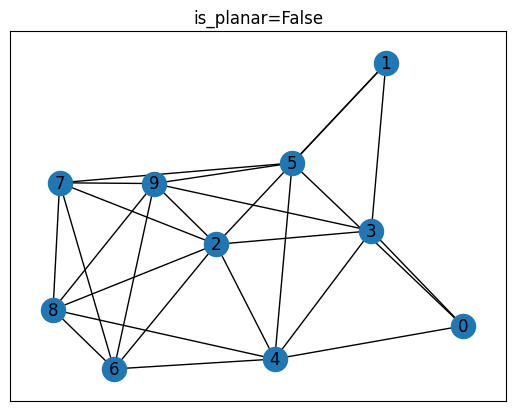

In [10]:
visualize(ds_onehot_8[0])

In [11]:
onehot_8_train_loader, onehot_8_test_loader = split_dataset(ds_onehot_8)

Number of training graphs: 800000
Number of test graphs: 200000


GCN(
  (conv1): GCNConv(11, 11)
  (conv2): GCNConv(11, 11)
  (conv3): GCNConv(11, 11)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.9626, precision=0.9336, recall=0.8908, size=800000.0000, f1=0.9117, Test: accuracy=0.9624, precision=0.9320, recall=0.8910, size=200000.0000, f1=0.9110
Epoch:  02, Train: accuracy=0.9637, precision=0.9273, recall=0.9032, size=800000.0000, f1=0.9151, Test: accuracy=0.9634, precision=0.9266, recall=0.9023, size=200000.0000, f1=0.9143
Epoch:  03, Train: accuracy=0.9658, precision=0.9219, recall=0.9200, size=800000.0000, f1=0.9210, Test: accuracy=0.9657, precision=0.9212, recall=0.9202, size=200000.0000, f1=0.9207
Epoch:  04, Train: accuracy=0.9659, precision=0.9325, recall=0.9085, size=800000.0000, f1=0.9203, Test: accuracy=0.9655, precision=0.9314, recall=0.9070, size=200000.0000, f1=0.9191
Epoch:  05, Train: accuracy=0.9653, precision=0.9351, recall=0.9027, size=800000.0000, f1=0.9186, Test: accuracy=0.9651, prec

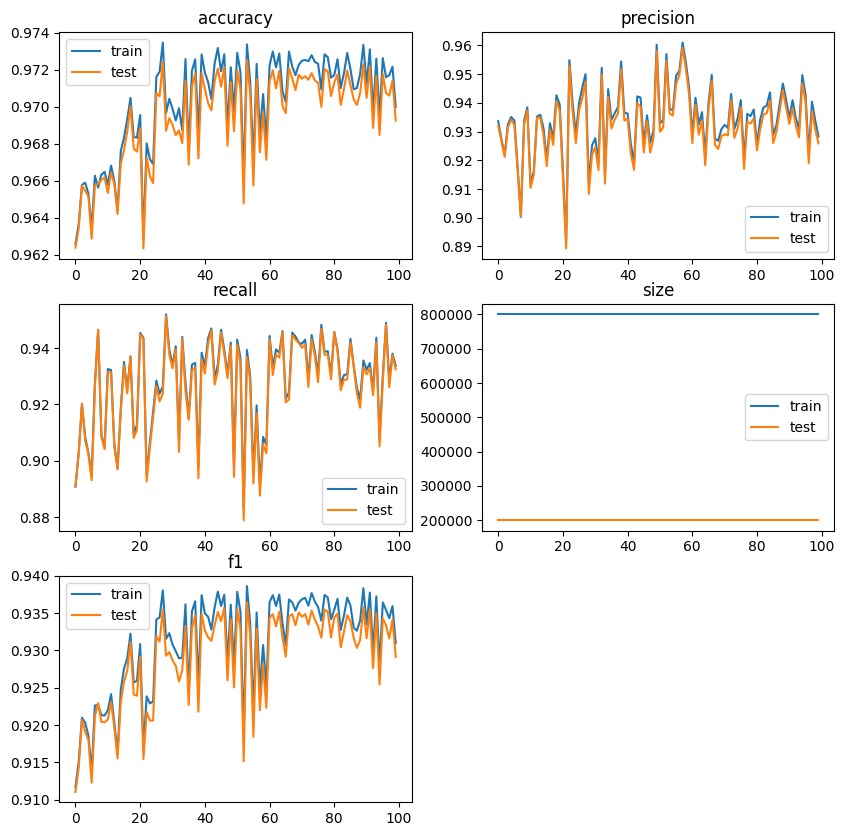

In [23]:
gcn_model = GCN(hidden_channels=11, num_node_features=ds_onehot_8.num_node_features,
            num_classes=ds_onehot_8.num_classes)
print(gcn_model)

te = TrainEval(gcn_model)
te.main(NUM_EPOCH, onehot_8_train_loader, onehot_8_test_loader)

SAGE(
  (conv1): SAGEConv(11, 11, aggr=mean)
  (conv2): SAGEConv(11, 11, aggr=mean)
  (conv3): SAGEConv(11, 11, aggr=mean)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.9785, precision=0.9708, recall=0.9288, size=800000.0000, f1=0.9493, Test: accuracy=0.9782, precision=0.9698, recall=0.9278, size=200000.0000, f1=0.9484
Epoch:  02, Train: accuracy=0.9790, precision=0.9507, recall=0.9527, size=800000.0000, f1=0.9517, Test: accuracy=0.9786, precision=0.9487, recall=0.9526, size=200000.0000, f1=0.9506
Epoch:  03, Train: accuracy=0.9822, precision=0.9591, recall=0.9587, size=800000.0000, f1=0.9589, Test: accuracy=0.9821, precision=0.9577, recall=0.9594, size=200000.0000, f1=0.9586
Epoch:  04, Train: accuracy=0.9826, precision=0.9711, recall=0.9479, size=800000.0000, f1=0.9594, Test: accuracy=0.9826, precision=0.9707, recall=0.9478, size=200000.0000, f1=0.9592
Epoch:  05, Train: accuracy=0.9801, precision=0.9810, recall=0.9263, size=800000.0000, f

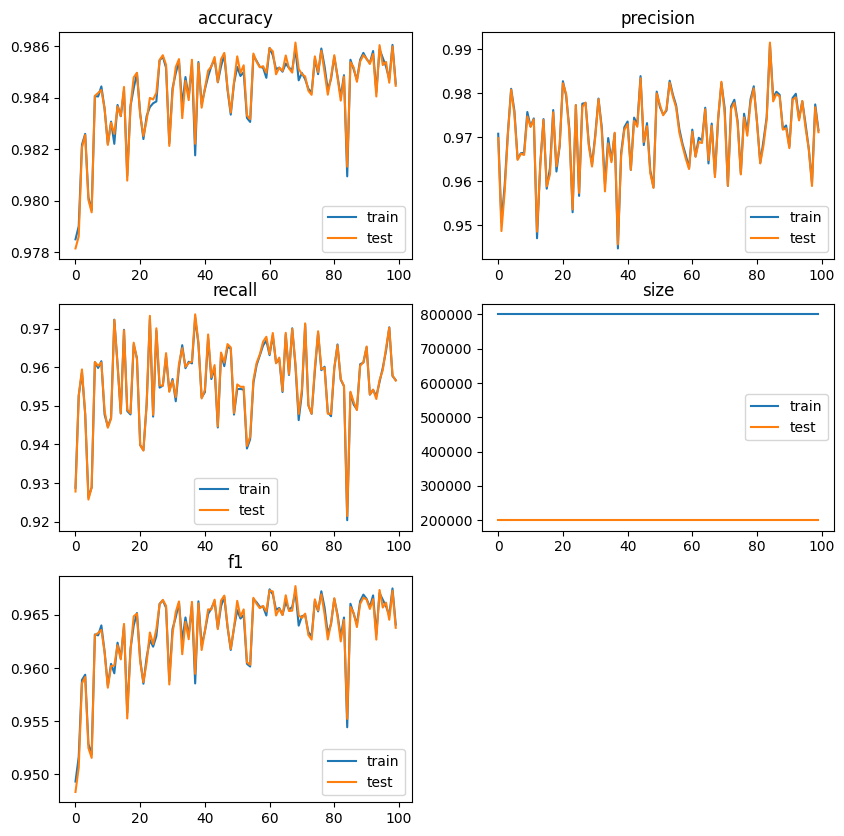

In [24]:
sage_model = SAGE(hidden_channels=11, num_node_features=ds_onehot_8.num_node_features,
                  num_classes=ds_onehot_8.num_classes)
print(sage_model)

te = TrainEval(sage_model)
te.main(NUM_EPOCH, onehot_8_train_loader, onehot_8_test_loader)

ConvGNN(
  (conv1): GraphConv(11, 11)
  (conv2): GraphConv(11, 11)
  (conv3): GraphConv(11, 11)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.9781, precision=0.9619, recall=0.9362, size=800000.0000, f1=0.9489, Test: accuracy=0.9778, precision=0.9604, recall=0.9357, size=200000.0000, f1=0.9479
Epoch:  02, Train: accuracy=0.9775, precision=0.9634, recall=0.9315, size=800000.0000, f1=0.9472, Test: accuracy=0.9772, precision=0.9622, recall=0.9313, size=200000.0000, f1=0.9465
Epoch:  03, Train: accuracy=0.9774, precision=0.9338, recall=0.9639, size=800000.0000, f1=0.9486, Test: accuracy=0.9773, precision=0.9334, recall=0.9637, size=200000.0000, f1=0.9483
Epoch:  04, Train: accuracy=0.9798, precision=0.9649, recall=0.9411, size=800000.0000, f1=0.9528, Test: accuracy=0.9794, precision=0.9632, recall=0.9408, size=200000.0000, f1=0.9518
Epoch:  05, Train: accuracy=0.9803, precision=0.9722, recall=0.9358, size=800000.0000, f1=0.9537, Test: accuracy=0.

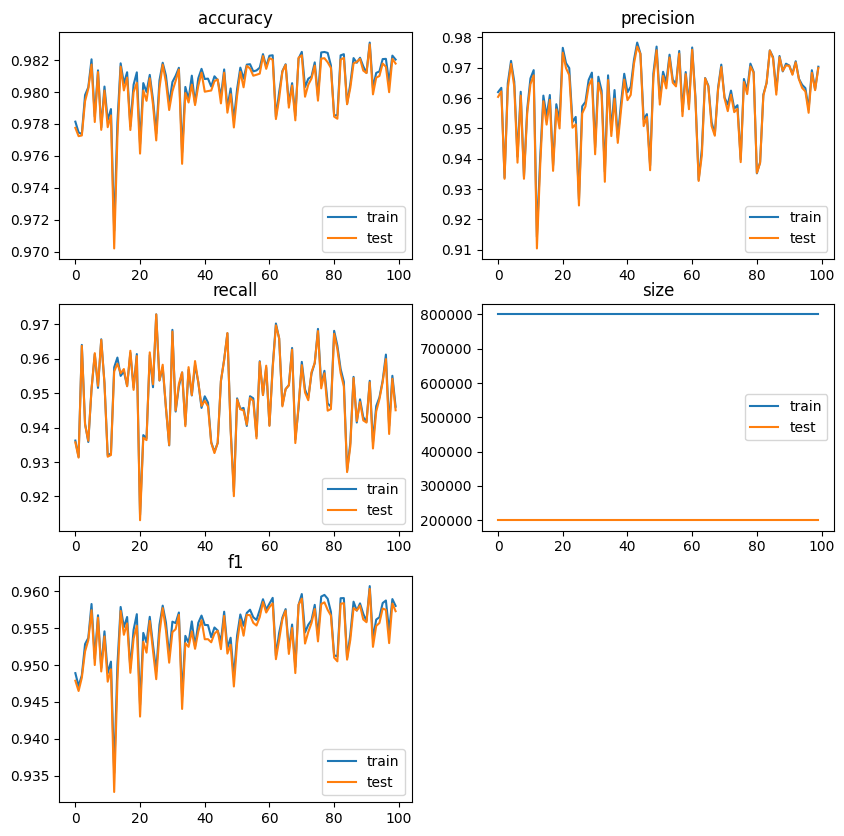

In [40]:
conv_model = ConvGNN(hidden_channels=11, num_node_features=ds_onehot_8.num_node_features,
                     num_classes=2)
print(conv_model)

te = TrainEval(conv_model)
te.main(NUM_EPOCH, onehot_8_train_loader, onehot_8_test_loader)

## NN

Epoch:  01, Train: accuracy=0.9302, precision=0.9539, recall=0.7125, size=800000.0000, f1=0.8157, Test: accuracy=0.9301, precision=0.9530, recall=0.7117, size=200000.0000, f1=0.8149
Epoch:  02, Train: accuracy=0.9454, precision=0.9069, recall=0.8336, size=800000.0000, f1=0.8687, Test: accuracy=0.9450, precision=0.9058, recall=0.8321, size=200000.0000, f1=0.8674
Epoch:  03, Train: accuracy=0.9464, precision=0.8880, recall=0.8613, size=800000.0000, f1=0.8745, Test: accuracy=0.9461, precision=0.8868, recall=0.8606, size=200000.0000, f1=0.8735
Epoch:  04, Train: accuracy=0.9448, precision=0.8736, recall=0.8712, size=800000.0000, f1=0.8724, Test: accuracy=0.9445, precision=0.8732, recall=0.8692, size=200000.0000, f1=0.8712
Epoch:  05, Train: accuracy=0.9428, precision=0.9183, recall=0.8079, size=800000.0000, f1=0.8595, Test: accuracy=0.9424, precision=0.9180, recall=0.8056, size=200000.0000, f1=0.8581
Epoch:  06, Train: accuracy=0.9460, precision=0.8883, recall=0.8589, size=800000.0000, f1=

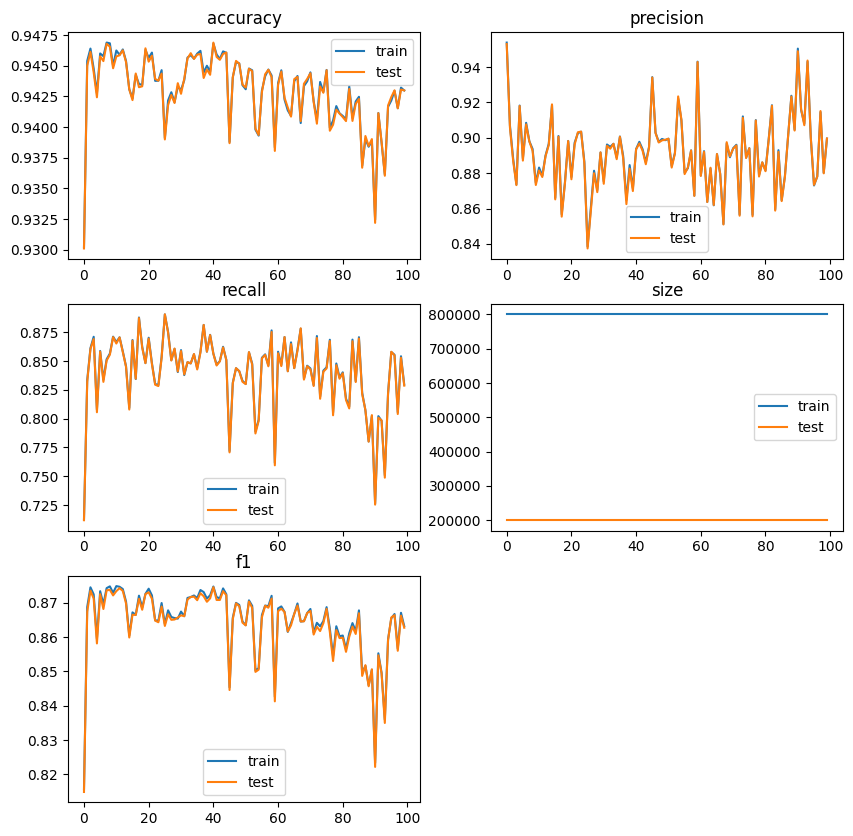

In [12]:
fc_model = nn.Sequential(
    nn.Linear(11, 100),
    nn.ReLU(),
    nn.Linear(100, 1000),
    nn.ReLU(),
    nn.Linear(1000, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.ReLU(),
    nn.Linear(10, 2),
)

te = TrainEvalGraphless(fc_model)
te.main(NUM_EPOCH, onehot_8_train_loader, onehot_8_test_loader)

# Features: constant, avg_nodes: 8

In [ ]:
%%time

torch.manual_seed(1234)
np.random.seed(3241)
random.seed(4534)

avg_degree = 4
max_degree = avg_degree * 5 // 2

constant = Constant(value=1.0, cat=False)

ds_const_8 = FakeDatasetIsPlanar(num_graphs=NUM_GRAPHS, avg_num_nodes=8, avg_degree=avg_degree,
                               transform=constant)

print(f"Planar graphs: {int(ds_const_8.y.sum())}")
ds_const_8

In [ ]:
visualize(ds_const_8[0])

In [15]:
ds_const_8_train_loader, ds_const_8_test_loader = split_dataset(ds_const_8)

Number of training graphs: 800000
Number of test graphs: 200000


In [ ]:
gcn_model = GCN(hidden_channels=10, num_node_features=ds_const_8.num_node_features,
            num_classes=ds_const_8.num_classes)
print(gcn_model)

te = TrainEval(gcn_model)
te.main(NUM_EPOCH, ds_const_8_train_loader, ds_const_8_test_loader)

GCN(
  (conv1): GCNConv(1, 10)
  (conv2): GCNConv(10, 10)
  (conv3): GCNConv(10, 10)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.7832, precision=0.0000, recall=0.0000, size=800000.0000, f1=0.0000, Test: accuracy=0.7838, precision=0.0000, recall=0.0000, size=200000.0000, f1=0.0000
Epoch:  02, Train: accuracy=0.7832, precision=0.0000, recall=0.0000, size=800000.0000, f1=0.0000, Test: accuracy=0.7838, precision=0.0000, recall=0.0000, size=200000.0000, f1=0.0000
Epoch:  03, Train: accuracy=0.7832, precision=0.0000, recall=0.0000, size=800000.0000, f1=0.0000, Test: accuracy=0.7838, precision=0.0000, recall=0.0000, size=200000.0000, f1=0.0000
Epoch:  04, Train: accuracy=0.7832, precision=0.0000, recall=0.0000, size=800000.0000, f1=0.0000, Test: accuracy=0.7838, precision=0.0000, recall=0.0000, size=200000.0000, f1=0.0000
Epoch:  05, Train: accuracy=0.7832, precision=0.0000, recall=0.0000, size=800000.0000, f1=0.0000, Test: accuracy=0.7838, preci

In [ ]:
sage_model = SAGE(hidden_channels=10, num_node_features=ds_const_8.num_node_features,
                  num_classes=ds_const_8.num_classes)
print(sage_model)

te = TrainEval(sage_model)
te.main(NUM_EPOCH, ds_const_8_train_loader, ds_const_8_test_loader)

In [ ]:
conv_model = ConvGNN(hidden_channels=10, num_node_features=ds_const_8.num_node_features,
                     num_classes=ds_const_8.num_classes)
print(conv_model)

te = TrainEval(conv_model)
te.main(NUM_EPOCH, ds_const_8_train_loader, ds_const_8_test_loader)